# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import string

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Import custom plotting function
from plotter import scatter_linregress

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

# Figure size for scatter plots
figsize=(10, 5)

## Generate Cities List

In [2]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
num_of_cities = len(cities)
print(num_of_cities)

608


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it's being processed (with the city number and city name).

In [ ]:
# Openweathermap api url
url = "http://api.openweathermap.org/data/2.5/weather"
units = 'imperial'
params = {'units': units,
          'appid': weather_api_key}

print("""Beginning Data Retrieval
-----------------------------""")
d = []
for idx, city in enumerate(cities, 1):
    # 60 calls/min = 1 call per second
    time.sleep(1)
    
    # set city param
    params['q'] = city
    print(f"Processing Record {idx} of {num_of_cities} | {string.capwords(city)}")
    response = requests.get(url=url, params=params)
    data = response.json()
    # check if city not found
    if data['cod'] == '404':
        print(f"{string.capwords(city)} not found. Skipping...")
        continue
    
    # create new dict entry
    d.append(
        {
            'City': data['name'],
            'Lat': data['coord']['lat'],
            'Lng': data['coord']['lon'],
            'Max_Temp': data['main']['temp_max'],
            'Humidity': data['main']['humidity'],
            'Cloudiness': data['clouds']['all'],
            'Wind_Speed': data['wind']['speed'],
            'Country': data['sys']['country'],
            'Date': pd.to_datetime(data['dt'], unit='s')
        }
    )

print("""-----------------------------
Data Retrieval Complete
-----------------------------""")

### If API Calls Was Run, Run This Cell

In [ ]:
weather_df = pd.DataFrame(d)
weather_df.to_csv('weather.csv', index=False)
weather_df.head()

### If Accessing Saved Data, Run This Cell

In [3]:
weather_df = pd.read_csv('weather.csv')
weather_df.head()

,City,Lat,Lng,Max_Temp,Humidity,Cloudiness,Wind_Speed,Country,Date
0,Oddur,4.12,43.89,82.53,44,98,22.21,SO,2020-07-23 13:43:00
1,Mahébourg,-20.41,57.70,69.80,64,75,19.46,MU,2020-07-23 13:46:50
2,Ürümqi,43.80,87.60,80.60,32,75,4.47,CN,2020-07-23 13:46:53
3,Grajaú,-5.82,-46.14,88.41,39,100,8.90,BR,2020-07-23 13:46:54
4,Saskylakh,71.92,114.08,53.13,92,99,12.93,RU,2020-07-23 13:42:06


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [4]:
# Get initial data length
data_len = len(weather_df)
weather_df = weather_df.drop(weather_df[weather_df.Humidity > 100].index)
print(f"Removed {data_len - len(weather_df)} cities with Humidity values greater than 100%")

Removed 0 cities with Humidity values greater than 100%


In [5]:
# Write cleaned csv to file
weather_df.to_csv('weather.csv', index=False)

## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

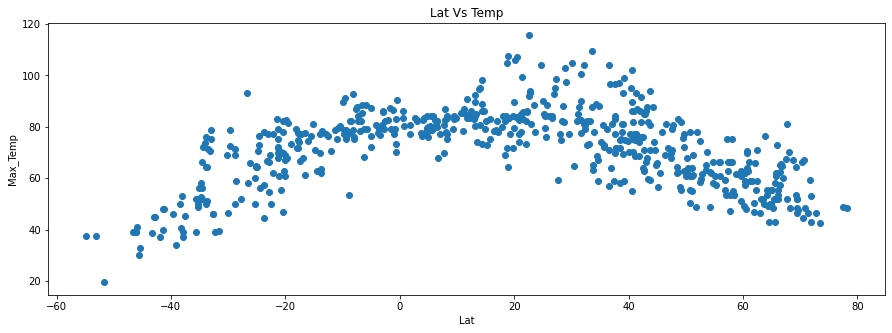

In [9]:
fig, axes = plt.subplots(1, 1, figsize=(15,5))

scatter_linregress(axes, weather_df['Lat'], weather_df['Max_Temp'], "Lat Vs Temp", regress=False)

plt.show()

## Latitude vs. Humidity Plot

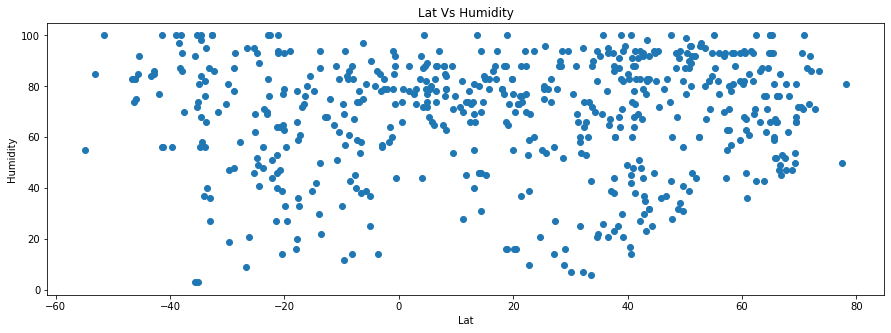

In [10]:
fig, axes = plt.subplots(1, 1, figsize=(15,5))

scatter_linregress(axes, weather_df['Lat'], weather_df['Humidity'], "Lat Vs Humidity", regress=False)

plt.show()

## Latitude vs. Cloudiness Plot

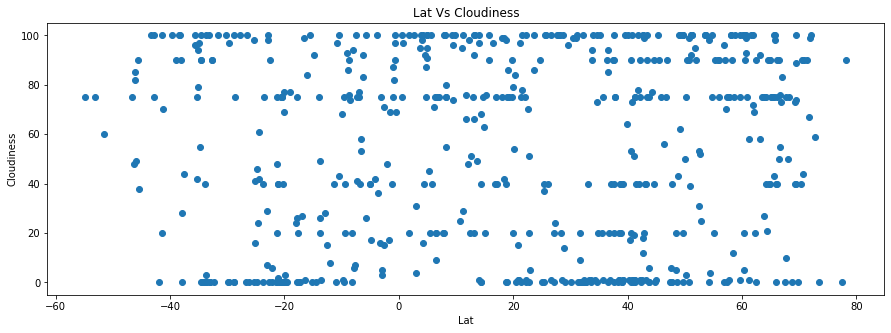

In [11]:
fig, axes = plt.subplots(1, 1, figsize=(15,5))

scatter_linregress(axes, weather_df['Lat'], weather_df['Cloudiness'], "Lat Vs Cloudiness", regress=False)

plt.show()

## Latitude vs. Wind Speed Plot

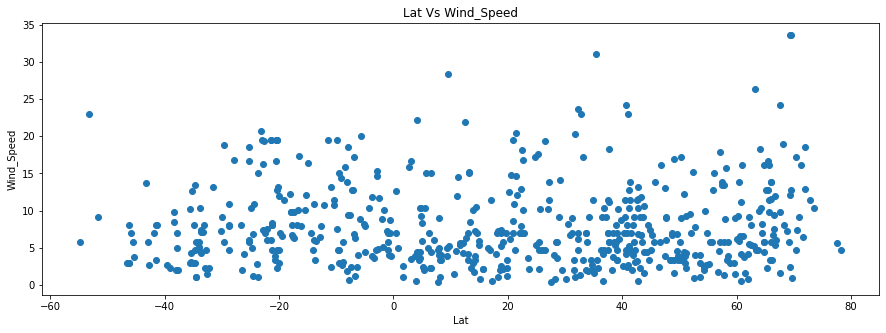

In [12]:
fig, axes = plt.subplots(1, 1, figsize=(15,5))

scatter_linregress(axes, weather_df['Lat'], weather_df['Wind_Speed'], "Lat Vs Wind_Speed", regress=False)

plt.show()

In [14]:
# split the datset into north and south hemispheres
north_hemis_df = weather_df.drop(weather_df[weather_df['Lat'] < 0].index)
south_hemis_df = weather_df.drop(weather_df[weather_df['Lat'] >= 0].index)

#### Hemispheres - Max Temp vs. Latitude Linear Regression

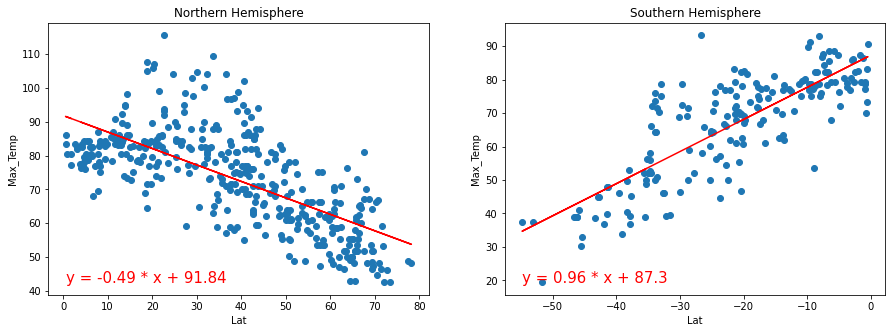

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

# Northern Hemisphere plot
scatter_linregress(axes[0], north_hemis_df['Lat'], north_hemis_df['Max_Temp'], "Northern Hemisphere")

# Southern Hemisphere
scatter_linregress(axes[1], south_hemis_df['Lat'], south_hemis_df['Max_Temp'], "Southern Hemisphere")

plt.show()

####  Hemispheres - Humidity (%) vs. Latitude Linear Regression

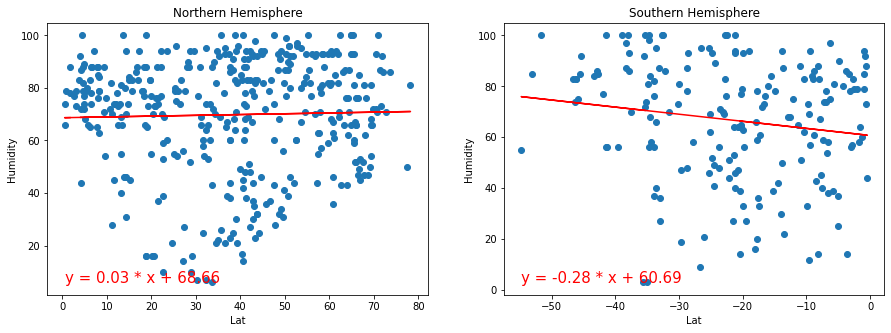

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

# Northern Hemisphere plot
scatter_linregress(axes[0], north_hemis_df['Lat'], north_hemis_df['Humidity'], "Northern Hemisphere")

# Southern Hemisphere
scatter_linregress(axes[1], south_hemis_df['Lat'], south_hemis_df['Humidity'], "Southern Hemisphere")

plt.show()

####  Hemispheres - Cloudiness (%) vs. Latitude Linear Regression

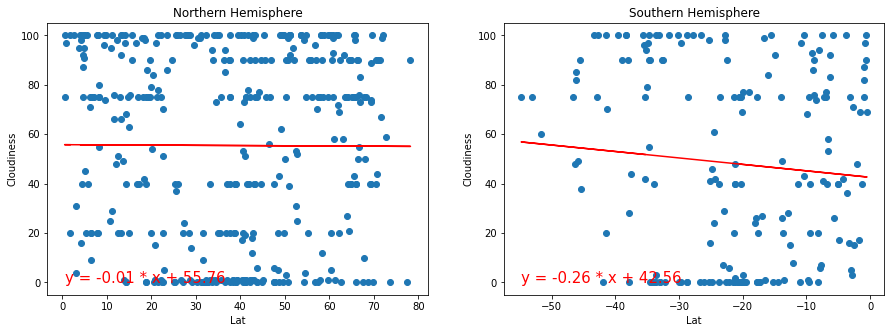

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

# Northern Hemisphere plot
scatter_linregress(axes[0], north_hemis_df['Lat'], north_hemis_df['Cloudiness'], "Northern Hemisphere")

# Southern Hemisphere
scatter_linregress(axes[1], south_hemis_df['Lat'], south_hemis_df['Cloudiness'], "Southern Hemisphere")

plt.show()

####  Hemispheres - Wind Speed (mph) vs. Latitude Linear Regression

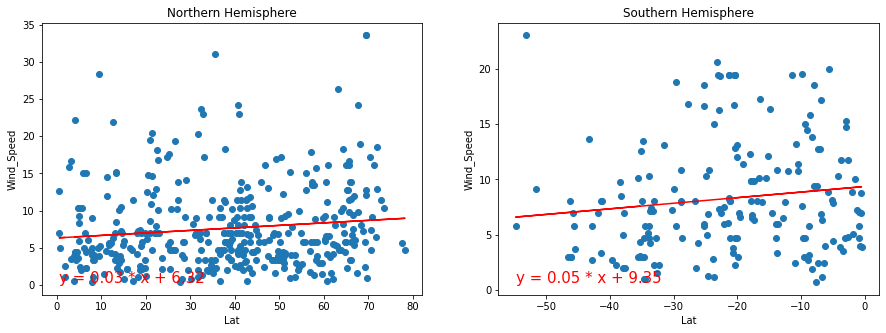

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

# Northern Hemisphere plot
scatter_linregress(axes[0], north_hemis_df['Lat'], north_hemis_df['Wind_Speed'], "Northern Hemisphere")

# Southern Hemisphere
scatter_linregress(axes[1], south_hemis_df['Lat'], south_hemis_df['Wind_Speed'], "Southern Hemisphere")

plt.show()